In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("covid_part2.ipynb")

# Final Project: COVID-19 Dataset
## Exploring COVID-19 Data through Modeling
## Due Date: Thursday, December 13th, 11:59 PM
## Collaboration Policy

Data science is a collaborative activity. While you may talk with other groups about
the project, we ask that you **write your solutions individually**. If you do
discuss the assignments with others outside of your group please **include their names** at the top
of your notebook.


## This Assignment

In this final project, we will investigate COVID-19 data over the past year. This data contains information about COVID-19 case counts, mortalities, vaccination rates, and various other metadata that can assist in modeling various aspects of COVID-19.

Through this final project, you will demonstrate your experience with:
* Data cleaning and EDA using Pandas
* Unsupervised and supervised learning techniques
* Visualization


## Goal

Model and analyze the temporal evolution of COVID-19 mortalities or cases using one unsupervised and one supervised technique of your choice. Interpret your models' results through visualizations, and draw insightful conclusions about the modeling of COVID-19 data.

Recall that we studied linear and logistic regression, decision trees, random forests as part of supervised learning (with labels) and clustering, PCA as part of unsupervised learning (without labels). You are free to use any methods that you find suitable to answer the problem at hand.

In [2]:
pip install geopy

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Run this cell to set up your notebook
import numpy as np
from geopy import *
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.cluster import *
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from scipy.stats import pearsonr
import re

cases = pd.read_csv('data/time_series_covid19_confirmed_US.csv') # https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv
vaccinations = pd.read_csv('data/people_vaccinated_us_timeline.csv') # https://raw.githubusercontent.com/govex/COVID-19/master/data_tables/vaccine_data/us_data/time_series/people_vaccinated_us_timeline.csv
counties = pd.read_csv('data/co-est2020.csv', encoding='latin-1') # https://www2.census.gov/programs-surveys/popest/datasets/2010-2020/counties/totals/co-est2020.csv
mask_use = pd.read_csv('data/mask-use-by-county.csv') # https://github.com/nytimes/covid-19-data/blob/master/mask-use/mask-use-by-county.csv

<br/><br/><br/>

---

<br/><br/><br/>

## Data Cleaning (Again!)

For this section, please copy over the appropriate answers from your previous notebook submission.

### Part 1: Question 1a

Impute the null values in *all* the datasets with zero values or empty strings where appropriate.

<!--
BEGIN QUESTION
name: q1a
points: 0
-->

In [4]:
def autofill(df):
    for col in df:
        if df[col].dtype == 'string':
            df[col] = df[col].fillna("")
        else: 
            df[col] = df[col].fillna(0)
            
autofill(cases)
autofill(vaccinations)
autofill(mask_use)
autofill(counties)

In [5]:
grader.check("q1a")

q1a results: All test cases passed!

### Part 1: Question 1d

Generate a valid FIPS code for the `counties` table.

*Hint*: Refer to [this](https://transition.fcc.gov/oet/info/maps/census/fips/fips.txt) guide on FIPS codes.

<!--
BEGIN QUESTION
name: q1d
points: 0
-->

In [6]:
counties['FIPS'] = counties['STATE'] * 1000 + counties['COUNTY']

In [7]:
grader.check("q1d")

q1d results: All test cases passed!

### Part 1: Question 1e

Merge the `counties`, `cases`, and `mask_use` tables on an appropriate primary key to generate county-wise data.

<!--
BEGIN QUESTION
name: q1e
points: 0
-->

In [8]:
county_data = counties.merge(cases, on='FIPS').merge(mask_use, left_on= 'FIPS', right_on = 'COUNTYFP')
county_data

,SUMLEV,REGION,DIVISION,STATE,COUNTY,STNAME,CTYNAME,CENSUS2010POP,ESTIMATESBASE2010,POPESTIMATE2010,...,9/9/21,9/10/21,9/11/21,9/12/21,COUNTYFP,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS
0,50,3,6,1,1,Alabama,Autauga County,54571,54582,54761,...,9145,9207,9246,9287,1001,0.053,0.074,0.134,0.295,0.444
1,50,3,6,1,3,Alabama,Baldwin County,182265,182263,183121,...,34536,34726,34872,34950,1003,0.083,0.059,0.098,0.323,0.436
2,50,3,6,1,5,Alabama,Barbour County,27457,27454,27325,...,3243,3260,3282,3295,1005,0.067,0.121,0.120,0.201,0.491
3,50,3,6,1,7,Alabama,Bibb County,22915,22904,22858,...,3727,3752,3778,3795,1007,0.020,0.034,0.096,0.278,0.572
4,50,3,6,1,9,Alabama,Blount County,57322,57322,57372,...,9048,9095,9161,9176,1009,0.053,0.114,0.180,0.194,0.459
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3136,50,4,8,56,37,Wyoming,Sweetwater County,43806,43806,43580,...,6034,6111,6111,6111,56037,0.061,0.295,0.230,0.146,0.268
3137,50,4,8,56,39,Wyoming,Teton County,21294,21298,21298,...,4587,4611,4611,4611,56039,0.095,0.157,0.160,0.247,0.340
3138,50,4,8,56,41,Wyoming,Uinta County,21118,21121,21090,...,3168,3204,3204,3204,56041,0.098,0.278,0.154,0.207,0.264
3139,50,4,8,56,43,Wyoming,Washakie County,8533,8528,8531,...,1111,1120,1120,1120,56043,0.204,0.155,0.069,0.285,0.287


In [9]:
grader.check("q1e")

q1e results: All test cases passed!

<br/><br/><br/>

---

<br/><br/><br/>

## Question 5: Guided Supervised Modeling

This section will guide you through creating a supervised learning framework that will predict the number of COVID-19 cases per capita given various COVID-19 safety protocols that have been implemented. Then, we will investigate the bias, variance, and observational noise of this framework.

Note that any answer responses without the appropriate work (i.e. code or math) will be subject to additional review and will not receive any credit.

<!-- BEGIN QUESTION -->

### Question 5a

We will use county-wise mask usage data to predict the number of COVID-19 cases on September 12th, 2021. Create a visualization that shows the pairwise correlation between each combination of column in the mask usage data and the number of COVID-19 cases.

*Hint*: You should be plotting 36 correlations.
<!--
BEGIN QUESTION
name: q5a
points: 3
manual: True
-->

In [10]:
#data_5a = county_data.copy()
#data_5a['Total Cases'] = np.sum(cases.iloc[:, 11:], axis=1)
#sns.heatmap(data_5a[['NEVER', 'RARELY', 'SOMETIMES', 'FREQUENTLY', 'ALWAYS', 'Total Cases']].corr())
#plt.title('COVID-19 Cases on 9/12/21 vs. Frequency \nof Mask Usage, Correlation')

Text(0.5, 1.0, 'COVID-19 Cases on 9/12/21 vs. Frequency \nof Mask Usage, Correlation')

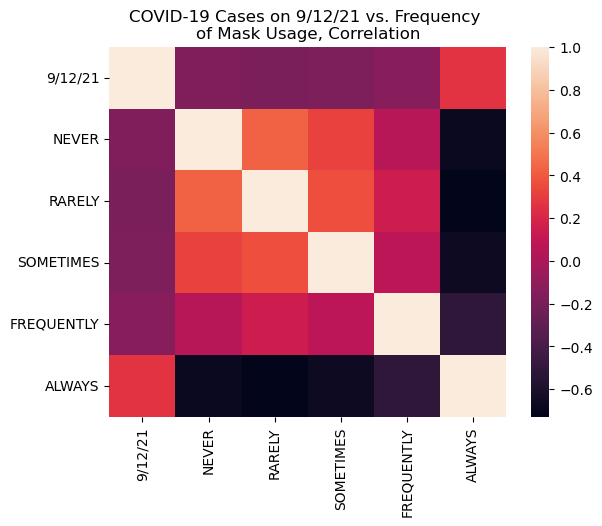

In [11]:
sns.heatmap(county_data[['9/12/21', 'NEVER', 'RARELY', 'SOMETIMES', 'FREQUENTLY', 'ALWAYS']].corr())
plt.title('COVID-19 Cases on 9/12/21 vs. Frequency \nof Mask Usage, Correlation')

<!-- END QUESTION -->

### Question 5b

Train a linear regression model to predict the number of COVID-19 cases using county-wise mask usage data for September 12, 2021. Evaluate your model's RMSE on a held-out validation set with 33% of the county-wise data. When possible, make sure to set `random_state = 42` when splitting your data into training and test sets.
<!--
BEGIN QUESTION
name: q5b
points: 5
-->

In [12]:
X_q5b = train_test_split(county_data[['NEVER', 'RARELY', 'SOMETIMES', 'FREQUENTLY', 'ALWAYS']], test_size = 0.33, random_state = 42)
y_q5b = train_test_split(county_data[['9/12/21']], test_size = 0.33, random_state = 42)

# Make sure to set random_state = 42 and test_size = 0.33!
X_q5b_train, X_q5b_test, y_q5b_train, y_q5b_test = X_q5b[0], X_q5b[1], y_q5b[0], y_q5b[1]

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

model_5b = LinearRegression()
model_5b.fit(X_q5b_train, y_q5b_train)
train_5bpredictions = model_5b.predict(X_q5b_train)
test_5bpredictions = model_5b.predict(X_q5b_test)

train_rmse_cases = rmse(train_5bpredictions, y_q5b_train)[0]
test_rmse_cases = rmse(test_5bpredictions, y_q5b_test)[0]

train_rmse_cases, test_rmse_cases

(27834.430707426982, 62591.13087482177)

In [13]:
grader.check("q5b")

q5b results: All test cases passed!

<!-- BEGIN QUESTION -->

### Question 5c

Explain potential reasons the test set RMSE is much higher as compared to the training set RMSE.
<!--
BEGIN QUESTION
name: q5c
points: 3
manual: True
-->

_The cases are very large values, while the mask_use values between counties is on a much smaller scale, and some counties may vary little. For a simple linear regression model, this can lead to overfitting where a small change in mask_use values leads to a very large change in the prediction of cases. This is likely why the test set RMSE is much higher as the model is assigning large differences in cases based on small differences in mask_use._

<!-- END QUESTION -->

### Question 5d

Instead of predicting the number of COVID-19 cases, redo part (b) by predicting the number of cases per capita. Report the model's RMSE on the training and validation set.

Comment on the relationship between the training and test RMSE by predicting the number of cases per capita instead of the total number of cases.
<!--
BEGIN QUESTION
name: q5d
points: 3
-->

In [14]:
X_q5d = train_test_split(county_data[['NEVER', 'RARELY', 'SOMETIMES', 'FREQUENTLY', 'ALWAYS']], test_size = 0.33, random_state = 42)
y_q5d = train_test_split(county_data[['9/12/21']].divide(county_data['POPESTIMATE2020'], axis=0), test_size = 0.33, random_state = 42)

# Make sure to set random_state = 42 and test_size = 0.33!
X_q5d_train, X_q5d_test, y_q5d_train, y_q5d_test = X_q5d[0], X_q5d[1], y_q5d[0], y_q5d[1]

model_5d = LinearRegression()
model_5d.fit(X_q5d_train, y_q5d_train)
train_5dpredictions = model_5d.predict(X_q5d_train)
test_5dpredictions = model_5d.predict(X_q5d_test)

train_rmse_cpc = rmse(train_5dpredictions, y_q5d_train)[0]
test_rmse_cpc = rmse(test_5dpredictions, y_q5d_test)[0]

train_rmse_cpc, test_rmse_cpc

(0.03540985737823185, 0.03816790349891603)

In [15]:
grader.check("q5d")

q5d results: All test cases passed!

<!-- BEGIN QUESTION -->

### Question 5e

Visualize the model outputs from part (d) by plotting the predictions $\hat{y}$ versus the observations $y$. Comment on what the plot indicates about our linear model as a comment in the code cell.

<!--
BEGIN QUESTION
name: q5e
points: 3
manual: True
-->

In [16]:
data = pd.DataFrame(index = (np.arange(len(y_q5d_test.values))))
data['x'] = test_5dpredictions
data['y'] = y_q5d_test.values

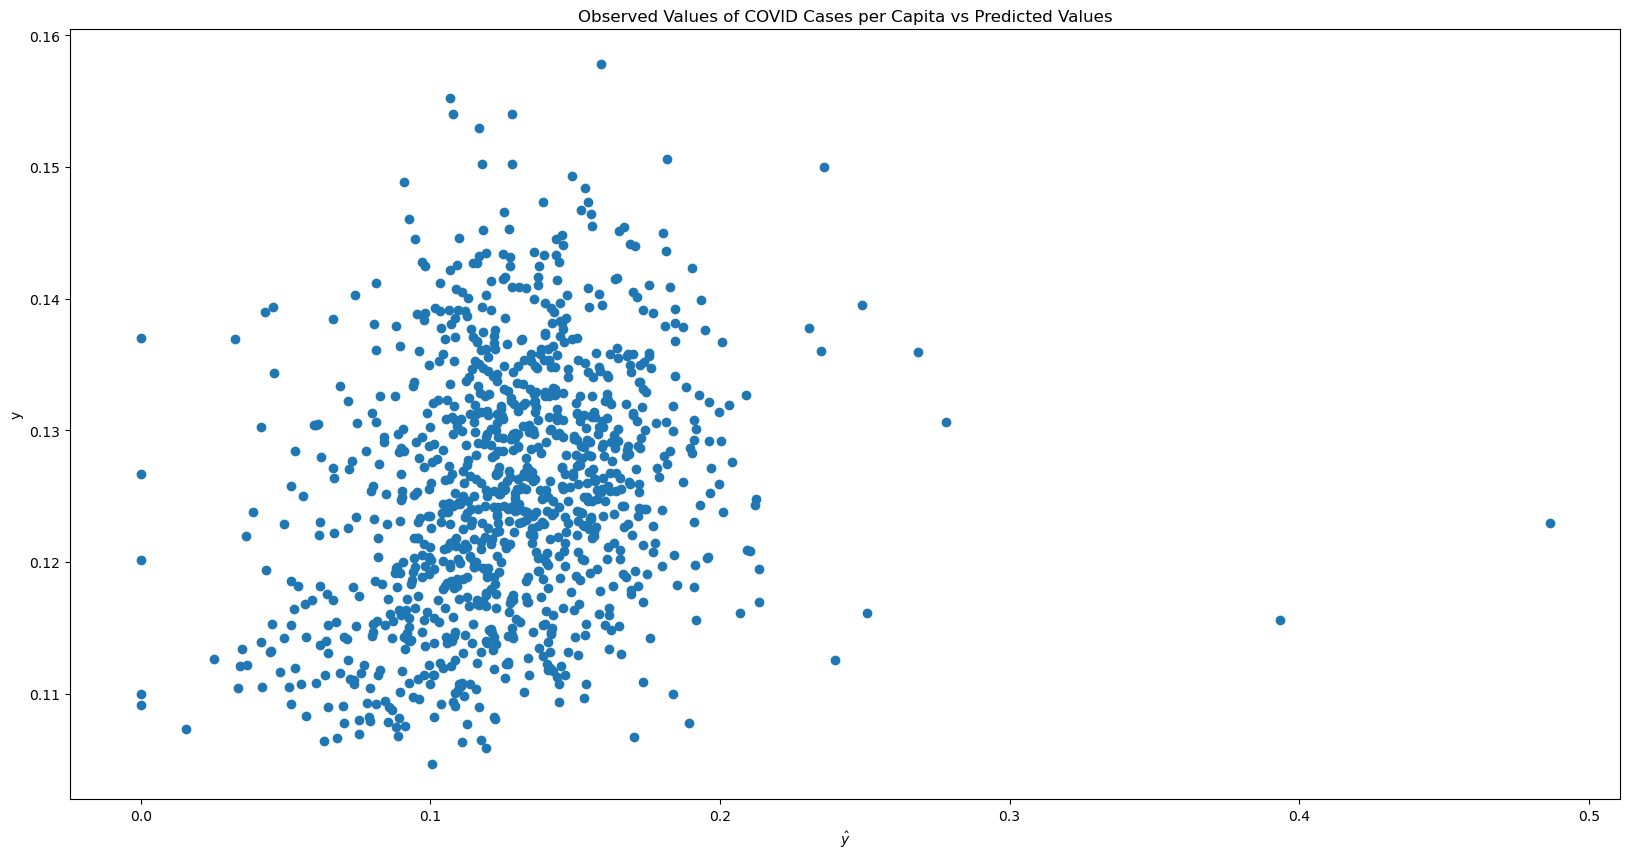

In [17]:
plt.figure(figsize = (20, 10))
plt.scatter(data = data, x = 'y', y = 'x')
plt.ylabel("y")
plt.xlabel("$\hat{y}$")
plt.title("Observed Values of COVID Cases per Capita vs Predicted Values");

<!-- END QUESTION -->

### Question 5f

We will investigate the bias and variance of this improved model on the test set using the bias-variance decomposition to formalize the behaviour of our model. To generate an empirical estimate of the errors and the parameters in the bias-variance decomposition, train 1000 bootstrapped models on the training dataset from part (d).

<!--
BEGIN QUESTION
name: q5f
points: 5
-->

In [18]:
models = [LinearRegression() for i in np.arange(1000)]
for model in models:
    xtrain = X_q5d_train.sample(frac=1, replace = True)
    ytrain = y_q5d_train.sample(frac=1, replace = True)
    model = model.fit(xtrain, ytrain)

In [19]:
grader.check("q5f")

q5f results: All test cases passed!

### Question 5g

To investigate the variance in our test predictions, we sample a particular test point $(x_i, y_i)$ such that $i = 100$. In other words, we will use the 100th point in the test set from part (d), `(X_q5d_test.iloc[100], y_q5d_test.iloc[100])` as the testing point.

Generate predictions and square errors for this test point for all 1000 models, and calculate the *proportion* of the *expected* square error that is captured by the model prediction variance. In other words, we wish to estimate the following quantity:

$$
\frac{\mathrm{Var}(f_\theta(x_i))}{\mathrm{E}_\theta[(y_i - f_\theta(x_i))^2]}
$$

*Hint*: Refer to the bias-variance decomposition from lecture.
<!--
BEGIN QUESTION
name: q5g
points: 5
-->

In [20]:
predictions = []
squareerrors = []
for model in models:
    prediction = model.predict([X_q5d_test.iloc[100]])[0][0]
    predictions.append(prediction)
    squareerrors.append((y_q5d_test.iloc[100][0] - prediction)**2)
    
prop_var = np.var(predictions)/np.mean(squareerrors)
prop_var

0.0009848588202218491

In [21]:
grader.check("q5g")

q5g results: All test cases passed!

<!-- BEGIN QUESTION -->

### Question 5h

Using the bias-variance decomposition, comment on how much the variance of the model contributes to the error on the sample point above. We will extend this scenario to analyze the noise term in the bias-variance decomposition, specifically with regards to this COVID-19 dataset. Consider the following:

i) Assuming no observational noise (i.e. $\epsilon = 0$), what is the *magnitude* of the empirical model bias on this sample point?

ii) Clearly, there is a non-trivial amount of observational noise with COVID-19 case data simply due to how testing works and occurs. Please take a look at [this article](https://fivethirtyeight.com/features/coronavirus-case-counts-are-meaningless/) for more information. Given this infomation, explain the issues with the assumptions and result in 5h(i).

iii) Recall that we typically assume $y = g(x) + \epsilon$, where $\epsilon \sim \mathcal{N}(\mu, \sigma)$. In the theoretical setting for bias-variance, we have assumed $\mu = 0, \sigma > 0$. In this practical setting, analyze and determine how $\epsilon$ could be modeled (as a normal distribution, but you may also consider how it could be modeled as another distribution). Are there any immediate issues with the assumptions we have made in the theoretical setting where $\mu = 0, \sigma > 0$? What conditions on $\mu, \sigma$ could be more appropriate and why?

iv) Does the standard bias-variance decomposition presented in lecture hold given $\epsilon$ being normally distributed according to your answer in part (iii)? If so, please explain why. If not, explain why it does not hold and if possible, how to modify the bias-variance decomposition to make it hold (i.e. perhaps there is an additional noise term $E[\epsilon^3]$). 

*Hint*: Try to express $y = g(x) + \epsilon$ by adding and subtracting a certain quantity.

v) Intuitively, is it possible to minimize the true model bias to 0 given your $\epsilon$ formulation in part (iii)? Why or why not? Justify your answer using part (iv) if possible.

vi) Consider the infinite sample case where an oracle grants you as many samples as requested, and answer the same question in part (v). Is it possible to minimize the true model bias to 0 given your $\epsilon$ formulation in part (iii)? Conclude with an analysis of what our modeling task can approximate using $X\theta \approx y$ in the finite and infinite sample case.

<!--
BEGIN QUESTION
name: q5h
points: 24
manual: True
-->

5i. error = observational noise + bias^2 + variance

error - 0 - variance = bias^2

bias = 0.001240375941844189

ii. As discussed in the article, COVID-19 case counts actually have a rather high amount of observational noise. The assumption made in 5h(i) is that there is zero observational noise, which is highly unlikely if not impossible. One major factor behind this that's covered in the article is the lag between infection and test result reporting. The article cites Wuhan and California as places in which there is a particularly large lag, meaning case counts on a given day are not representative of the number of people who have COVID on that day, or even of the number of people who tested themselves that day and got a positive result. The article also states that the false negative rate for COVID tests is as high as 30%, meaning that in many instances, case counts will be far lower than the number of people who actually have COVID. The data on false positives is less clear, but it appears that the false positive rate is nonzero, which also contradicts the assumption of 5h(i).

iii. According to a combination of intuition and the info in the article, it's more likely that COVID case counts are underreported than overreported. This is largely due to the differences in prevalence of false positives and false negatives, as well as the way in which people not getting tested affects case counts. This means that it is more likely for the case counts to be too low than too high, making it impossible for noise to be modeled with mu = 0, sigma > 0. 
Because we can pretty confidently say the noise is skewed towards underreporting, mu = 0 is wrong. The noise in COVID case reporting is having an impact in a particular direction, meaning the mean value of the noise cannot be 0. Underreported cases would be represented by a negative epsilon value, making our observed value y lower than the true value, g(x). 
By definition, standard deviation is a squared value. By the nature of COVID testing, its virtually impossible that the random noise will only ever take on one value. Therefore, sigma > 0 is an appropriate condition as there's gonna be some distance between at least some observed values and the mean.
It's significantly more difficult to say whether or not a normal distribution is appropriate. Given the available information, it's unclear which, if any, conditions of a normal distribution would be violated when modeling noise (assuming the mean is changed to a more appropriate value). Therefore, we will assume a normal distribution is appropriate as it's typically most appropriate for modeling the distribution of natural phenomena. 

iv. Yes it still holds. We would just have a noise variable with a negative value instead of 0. 

v. Yes it's possible. Bias is composed of g(x) and the expectation of our predicted value. Neither of those numbers are affected by the random noise term. 

vi. It would still be possible. Using this approximation, we could approximate (error - noise - variance) because we would be able to set bias to 0.

<!-- END QUESTION -->

### Question 5i

Using the bias-variance decomposition for each test point, calculate the average variance and average test mean-square error across the entire test set from part (d). In other words, estimate the following quantities:

$$
\frac{1}{n} \sum_i \mathrm{Var}(f_\theta(x_i))
$$

and

$$
\frac{1}{n} \sum_i \mathrm{E}_\theta[(y_i - f_\theta(x_i))^2]
$$

<!--
BEGIN QUESTION
name: q5i
points: 5
manual: False
-->

In [22]:
avg_var, avg_mse = [], []

for point in range(len(X_q5d_test)):
    
    predictions = []
    squareerrors = []
    for model in models:
        prediction = model.predict([X_q5d_test.iloc[point]])[0][0]
        predictions.append(prediction)
    vari = np.sum((predictions - np.mean(predictions))**2/(len(predictions)-1))
    avg_var.append(vari)
    bias = np.mean(predictions)-y_q5d_test.iloc[point][0]
    avg_mse.append(bias **2 + vari)
    #bias = np.mean(predictions)-y_q5d_test.iloc[point][0]
    #variance = np.sum((predictions - np.mean(predictions))**2/(len(predictions)-1))
    #prop_var = bias**2 + variance
    #prop_var

avg_var = np.sum(avg_var)/len(avg_var)
avg_mse =  np.sum(avg_mse)/len(avg_mse)
avg_var, avg_mse

(3.6609255416348734e-06, 0.0015619604809727428)

In [23]:
grader.check("q5i")

q5i results: All test cases passed!

<!-- BEGIN QUESTION -->

## Question 5j

Propose a solution to reducing the mean square error using the insights gained from the bias-variance decomposition above. What are the values of the quantities that have we estimated and what can be concluded about the remaining quantities? Please show all work that informs your analysis.

Assume that the standard bias-variance decomposition used in lecture can be applied here.
<!--
BEGIN QUESTION
name: q5j
points: 5
manual: True
-->

_To reduce MSE, we would want to decrease at least one of observational noise, model bias, and model variance while keeping the other terms constant. We can't change observational noise without changing testing protocols, so it will have to be either bias or variance. Due to the bias-variance tradeoff, this becomes more difficult. Since the bias term is squared in the bias-variance decomposition, a decrease in bias should outweigh the resulting increase in variance, thus reducing model risk, or MSE. We can decrease bias by increasing model complexity, or adding more features. This makes sense intuitively - right now we're only training our models on mask use. In Part 1, we determined through PCA that mask use wasn't the strongest predictor of cases, so there's clearly room for us to add new features to the model. ._

<!-- END QUESTION -->



<br/><br/><br/>

---

<br/><br/><br/>

## Question 6: Open Supervised Modeling

We wish to extend our modeling framework from Question 5 to make it more accurate; in other words, we wish to predict $f(x)$, a supervised learning output, based on past and current quantities. 

This section will serve as a rough guide on creating an autoregressive modeling framework for predicting a COVID-19 quantity of your choice (i.e. deaths, cases, vaccinations).

Note that if you do not wish to pursue time-based modeling of COVID-19, you may skip parts (d), (e), and (f). That being said, you are strongly encouraged to incorporate time-based modeling into your open-ended modeling design since it constitutes a large component of the provided datasets.

We will ***not*** grade these below questions individually (i.e. there are no points explicitly assigned to questions 6(a) to 6(f)); they are simply guiding questions and will be graded as part of the final project report. You should make sure to answer all of the questions (that are applicable to your open-ended modeling) in some form in the report.

<!-- BEGIN QUESTION -->

### Question 6a

Train a baseline model where $f$ is the model described in Question 0a and $x$ is a quantity of *your* choice. Note that you may used *any* supervised learning approach we have studied; you are not limited to a linear model.

<!--
BEGIN QUESTION
name: q6a
points: 0
manual: True
-->

In [24]:
#Read in county adjacency data, and define helper function to find adjacent counties given FIP
#https://www.census.gov/programs-surveys/geography/library/reference/county-adjacency-file.html
counties_adjacency = pd.read_csv("https://data.nber.org/census/geo/county-adjacency/2010/county_adjacency2010.csv")
def find_adjacent(fip):
    neighbors=counties_adjacency[counties_adjacency['fipscounty']==fip]['fipsneighbor'].tolist()
    neighbors.remove(fip)
    return neighbors

#Drop COUNTYFPs 2261, 2158, 46102, 15001, 15003, 15007 as they are missing from 'cases' or do not have neighbors, and we will unable to predict it in our model.
removed_counties = [2261, 2158, 46102, 15001, 15003, 15007]
part6_countydata = county_data.copy()
part6_countydata = part6_countydata[~(part6_countydata["COUNTYFP"].isin(removed_counties))].reset_index()
mask_use_6a = mask_use.copy()
mask_use_6a = mask_use[~(mask_use["COUNTYFP"].isin(removed_counties))].reset_index()
all_neighbors = []

#Iterate over mask_use and add 'ALWAYS' mask_use data of neighboring counties
for index, row in mask_use_6a.iterrows():
    neighbors = []
    for i in find_adjacent(row['COUNTYFP']):
        if i in mask_use_6a['COUNTYFP'].values:
            neighbor = (mask_use_6a[mask_use_6a['COUNTYFP']==i])
            mask_rate = neighbor['ALWAYS'].iloc[0]
            neighbors.append(mask_rate)
    all_neighbors.append(neighbors)
mask_use_6a['neighbors_alwaysmaskrate'] = all_neighbors
separated_maskneighbors_6a = pd.DataFrame([pd.Series(x) for x in mask_use_6a.neighbors_alwaysmaskrate])

# Need to trim dataframe due to large number of NaN values, which sklearn is unable to handle while fitting.
# The number of nan values in the 8th neighbor column is the point at which NaNs becomes more than half of the total entries in the column (arbitrary boundary). 
# So, drop column 7 and later.
part6_data = separated_maskneighbors_6a.drop(np.arange(7,len(separated_maskneighbors_6a.columns)), axis=1)

# Impute NaN values with the row mean
part6_data = part6_data.apply(lambda row: row.fillna(row.mean()), axis=1)

#Readd COUNTYFP values
part6_data['COUNTYFP'] = mask_use_6a['COUNTYFP']

#adding case data, drop counties
cases_per_capita_6 = part6_countydata.copy()
cases_per_capita_6['9/12/21'] = cases_per_capita_6.loc[:, '9/12/21'].divide(cases_per_capita_6['POPESTIMATE2020'], axis=0)
cases_per_capita_6 = cases_per_capita_6[['9/12/21', 'COUNTYFP']]
cases_per_capita_6 = cases_per_capita_6[~(cases_per_capita_6["COUNTYFP"].isin(removed_counties))].reset_index()

#Iterate over cases_per_capita_6 and add neighboring county case rates
all_neighbors = []
for index, row in cases_per_capita_6.iterrows():
    neighbors = []
    for i in find_adjacent(row['COUNTYFP']):
        if i in cases_per_capita_6['COUNTYFP'].values:
            neighbor = (cases_per_capita_6[cases_per_capita_6['COUNTYFP']==i])
            case_rate = neighbor['9/12/21'].iloc[0]
            neighbors.append(case_rate)
    all_neighbors.append(neighbors)
cases_per_capita_6['neighbors_caserate'] = all_neighbors
separated_caseneighbors_6a = pd.DataFrame([pd.Series(x) for x in cases_per_capita_6.neighbors_caserate])

#Drop neighbors over 7 and impute NaN values with the row mean
separated_caseneighbors_6a = separated_caseneighbors_6a.drop(np.arange(7,len(separated_caseneighbors_6a.columns)), axis=1).apply(lambda row: row.fillna(row.mean()), axis=1)
#Readd COUNTYFP values
separated_caseneighbors_6a['COUNTYFP'] = cases_per_capita_6['COUNTYFP']
#Merge with mask data
part6a_data = part6_data.merge(separated_caseneighbors_6a, on='COUNTYFP', how='inner', suffixes=('mask', 'case'))
part6a_data.head()

,0mask,1mask,2mask,3mask,4mask,5mask,6mask,COUNTYFP,0case,1case,2case,3case,4case,5case,6case
0,0.618,0.524,0.485,0.464,0.513,0.5208,0.520800,1001,0.136563,0.125547,0.165973,0.172389,0.142041,0.148503,0.148503
1,0.430,0.387,0.506,0.378,0.495,0.5240,0.453333,1003,0.189644,0.170943,0.166948,0.146879,0.149662,0.167069,0.165191
2,0.500,0.460,0.438,0.330,0.570,0.5620,0.538000,1005,0.144447,0.164096,0.164722,0.130407,0.099576,0.105722,0.102158
3,0.618,0.639,0.628,0.618,0.545,0.5320,0.596667,1007,0.136563,0.190866,0.163438,0.151491,0.154931,0.152046,0.158223
4,0.379,0.501,0.628,0.479,0.495,0.4290,0.485167,1009,0.159321,0.177482,0.163438,0.172843,0.159413,0.155663,0.164693


In [25]:
cases_per_capita_6.describe(percentiles=[.1, .5, .99])

,index,9/12/21,COUNTYFP
count,3136.000000,3136.000000,3136.000000
mean,1567.500000,0.126661,30411.318240
std,905.429548,0.037588,15150.225362
min,0.000000,0.000000,1001.000000
10%,313.500000,0.081143,9508.000000
50%,1567.500000,0.127342,29180.000000
99%,3103.650000,0.214811,55124.300000
max,3135.000000,0.486494,56045.000000


In [26]:
from sklearn.metrics import r2_score

X_q6a = train_test_split(part6a_data.drop(columns='COUNTYFP'), test_size = 0.33, random_state = 42)
y_q6a = train_test_split(cases_per_capita_6['9/12/21'], test_size = 0.33, random_state = 42)

X_q6a_train, X_q6a_test, y_q6a_train, y_q6a_test = X_q6a[0], X_q6a[1], y_q6a[0], y_q6a[1]

#Baseline model predicts case rate from mean of neighboring county case rates.
baseline_predictions = np.mean(X_q6a_test.iloc[:, 7:14], axis=1)
baseline_rmse = np.sqrt(np.mean((y_q6a_test - baseline_predictions)**2))
baseline_r2 = r2_score(y_q6a_test, baseline_predictions)

print(f"Baseline Test RMSE: {baseline_rmse}")
print(f"Baseline Test R^2: {baseline_r2}")

Baseline Test RMSE: 0.02878011117332395
Baseline Test R^2: 0.44365947058401967


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 6b

Improve your model from part (a). Specify the supervised model you choose and write $f(x)$ as a function of the chosen features and parameters in your model. Justify why you chose these features and how you expect they will correlate with the output you wish to predict.

<!--
BEGIN QUESTION
name: q6b
points: 0
manual: True
-->

In [27]:
model_6a = LinearRegression()
model_6a.fit(X_q6a_train, y_q6a_train)
case_trainpredictions_6a = model_6a.predict(X_q6a_train)
trainrmse_6a = np.sqrt(np.mean((y_q6a_train - case_trainpredictions_6a)**2))
trainr2_6a = r2_score(y_q6a_train, case_trainpredictions_6a)

case_testpredictions_6a = model_6a.predict(X_q6a_test)
testrmse_6a = np.sqrt(np.mean((y_q6a_test - case_testpredictions_6a)**2))
testr2_6a = r2_score(y_q6a_test, case_testpredictions_6a)


print(f"Train RMSE: {trainrmse_6a}")
print(f"Train R^2: {trainr2_6a}")
print(f"Test RMSE: {testrmse_6a}")
print(f"Test R^2: {testr2_6a}")

Train RMSE: 0.02616179134344437
Train R^2: 0.5021372504101781
Test RMSE: 0.02846628215832868
Test R^2: 0.45572640601700676


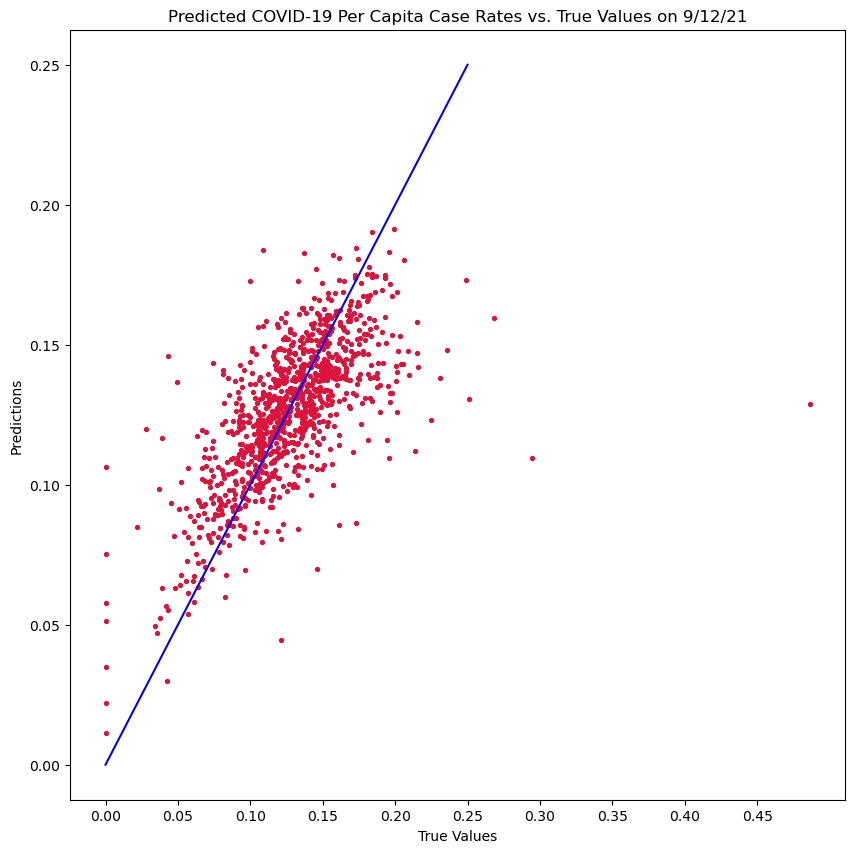

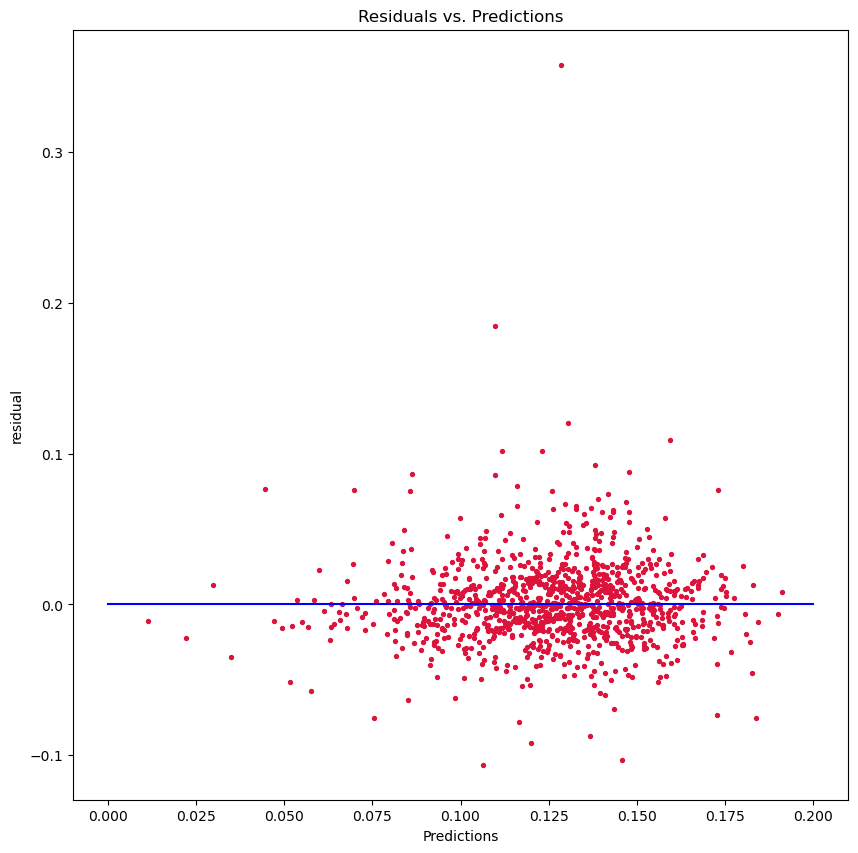

In [28]:
plt.figure(figsize=(10,10))
plt.scatter(x=y_q6a_test, y=case_testpredictions_6a, s=8, c='crimson')
plt.plot([0,0.25],[0,0.25], 'b-')
plt.xticks(np.arange(0, 0.5, step=0.05))
plt.yticks(np.arange(0, 0.3, step=0.05))
plt.title('Predicted COVID-19 Per Capita Case Rates vs. True Values on 9/12/21')
plt.xlabel('True Values')
plt.ylabel('Predictions');

residuals_6a = y_q6a_test - case_testpredictions_6a
plt.figure(figsize=(10,10))
plt.scatter(x=case_testpredictions_6a, y=residuals_6a, s=8, c='crimson')
plt.plot([0,0.2],[0,0], 'b-')
plt.title('Residuals vs. Predictions')
plt.xlabel('Predictions')
plt.ylabel('residual');

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 6c

If applicable, write an equation or rule for the prediction function $f(x)$; if this is infeasible, make sure to visualize your model parameters in some way. Interpret your improved model's optimal parameters (*hint*: refer to 1aiii), and compare these parameters to those of the baseline model. Comment on whether the parameters follow physical intuition given the nature of the prediction task.

For example, if you chose to use a decision tree, you may interpret the generated rules.
 
<!--
BEGIN QUESTION
name: q6c
points: 0
manual: True
-->

_Type your answer here, replacing this text._

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 6d

Discuss your improved model's performance on both short-term and long-term time scales using a metric of your choice (*hint:* we're using an autoregressive model). In other words, given $x_t$, we wish to predict $\hat{x}_{t+k}$, and plot the error of these predictions for two $k$ values of your choice. You may use any reasonable interpretation of short-term and long-term predictions; an initial suggestion is to use 2-day predictions and 2-week predictions.

Compare the performance of this model on both timescales with the baseline model.

<!--
BEGIN QUESTION
name: q6d
points: 0
manual: True
-->

In [29]:
def rmse(a, b):
    return np.sqrt(np.mean((a - b)**2))

def cases_day(date):
    #Date in format M/D/YY
    #Appends case data to part6a_data (baseline model data)
    cases_per_capita = part6_countydata.copy()
    cases_per_capita[date] = cases_per_capita.loc[:, date].divide(cases_per_capita['POPESTIMATE2020'], axis=0)
    cases_per_capita = cases_per_capita[[date, 'COUNTYFP']]
    all_neighbors = []
    for index, row in cases_per_capita.iterrows():
        neighbors = []
        for i in find_adjacent(row['COUNTYFP']):
            if i in cases_per_capita['COUNTYFP'].values:
                neighbor = (cases_per_capita[cases_per_capita['COUNTYFP']==i])
                case_rate = neighbor[date].iloc[0]
                neighbors.append(case_rate)
        all_neighbors.append(neighbors)
    cases_per_capita['neighbors_caserate'] = all_neighbors
    separated_caseneighbors = pd.DataFrame([pd.Series(x) for x in cases_per_capita.neighbors_caserate])
    separated_caseneighbors = separated_caseneighbors.drop(np.arange(7,len(separated_caseneighbors.columns)), axis=1).apply(lambda row: row.fillna(row.mean()), axis=1)
    separated_caseneighbors['COUNTYFP'] = cases_per_capita['COUNTYFP']
    return part6a_data.merge(separated_caseneighbors, on='COUNTYFP', how='inner', suffixes=('mask', 'case'))

def vaccinations_day(date, data):
    #Date in format YYYY-MM-DD
    #Appends vax data on 'date' to 'data'
    vax = vaccinations.copy()
    vax= vax[vax['Date']==date]
    vax_data = pd.DataFrame()
    for index, row in data.iterrows():
        statefp = np.trunc(row['COUNTYFP']/1000)
        statevax = vax[vax['FIPS']==statefp]
        vax_data = vax_data.append(statevax[['People_Fully_Vaccinated', 'People_Partially_Vaccinated']])
    vax_data = vax_data.reset_index()
    data = pd.concat([data, vax_data], axis=1).drop(columns=['index'])
    return data

def case_count_per_capita(date):
    cases_per_capita = part6_countydata.copy()
    cases_per_capita[date] = cases_per_capita.loc[:, date].divide(cases_per_capita['POPESTIMATE2020'], axis=0)
    cases_per_capita = cases_per_capita[[date, 'COUNTYFP']]
    return cases_per_capita[date]

In [30]:
part6a_data_improved = vaccinations_day('2021-09-12', part6a_data)
part6a_data_improved = part6a_data_improved[~(part6a_data_improved["COUNTYFP"].isin([13053, 8025]))]
cases_per_capita_6b = cases_per_capita_6[~(cases_per_capita_6["COUNTYFP"].isin([13053, 8025]))]

In [31]:
X_q6b = train_test_split(part6a_data_improved.drop(columns='COUNTYFP'), test_size = 0.33, random_state = 42)
y_q6b = train_test_split(cases_per_capita_6b['9/12/21'], test_size = 0.33, random_state = 42)

X_q6b_train, X_q6b_test, y_q6b_train, y_q6b_test = X_q6b[0], X_q6b[1], y_q6b[0], y_q6b[1]

model_6b = LinearRegression()
model_6b.fit(X_q6b_train, y_q6b_train)

case_trainpredictions_6b = model_6b.predict(X_q6b_train)
trainrmse_6b = np.sqrt(np.mean((y_q6b_train - case_trainpredictions_6b)**2))
trainr2_6b = r2_score(y_q6b_train, case_trainpredictions_6b)

case_testpredictions_6b = model_6b.predict(X_q6b_test)
testrmse_6b = np.sqrt(np.mean((y_q6b_test - case_testpredictions_6b)**2))
testr2_6b = r2_score(y_q6b_test, case_testpredictions_6b)

print(f"Improved Model Train RMSE: {trainrmse_6b}")
print(f"Improved Model Train R^2: {trainr2_6b}")
print(f"Improved Model Test RMSE: {testrmse_6b}")
print(f"Improved Model Test R^2: {testr2_6b}")

Improved Model Train RMSE: 0.025677239057559722
Improved Model Train R^2: 0.5190834920945658
Improved Model Test RMSE: 0.02591072112096292
Improved Model Test R^2: 0.48557062306933374


In [32]:
#Model train x-value: mask and case rate matrix from jan 1
X_jan_1 = cases_day('1/1/21')
#Model train y-value: actual cases per capita for each county
Y_jan_1 = case_count_per_capita('1/1/21')
model6d = LinearRegression()
model6d.fit(X_jan_1, Y_jan_1)

#2-day prediction: Predict from mask and case rate matrix for jan 3
X_jan_3 = cases_day('1/3/21')
pred_jan_3 = model6d.predict(X_jan_3)
#compare predictions with actual cases per capita from jan 3
Y_jan_3 = case_count_per_capita('1/3/21')
rmse_2day = rmse(Y_jan_3, pred_jan_3)
r2_2day = r2_score(Y_jan_3, pred_jan_3)

#2-week prediction: predict from mask case matrix for jan 15
X_jan_15 = cases_day('1/15/21')
pred_jan_15 = model6d.predict(X_jan_15)
#compare w/ actual from jan 15
Y_jan_15 = case_count_per_capita('1/15/21')
rmse_2week = rmse(Y_jan_15, pred_jan_15)
r2_2week = r2_score(Y_jan_15, pred_jan_15)

rmse_2day, r2_2day, rmse_2week, r2_2week

#Get baseline errors
baseline_pred = np.mean(cases_day("1/1/21").iloc[:, 8:14], axis=1)
rmse_baseline_2day = rmse(baseline_pred,Y_jan_3)
rmse_baseline_2week = rmse(baseline_pred, Y_jan_15)

print(f"Model RMSE for 2 days ahead: {rmse_2day} \n Model RMSE for 2 weeks ahead: {rmse_2week} \n Baseline RMSE for 2 days ahead: {rmse_baseline_2day} \n Baseline RMSE for 2 weeks ahead: {rmse_baseline_2week}")

Model RMSE for 2 days ahead: 0.019438078688468592 
 Model RMSE for 2 weeks ahead: 0.020398550339936244 
 Baseline RMSE for 2 days ahead: 0.06500161568388789 
 Baseline RMSE for 2 weeks ahead: 0.05791463965653096


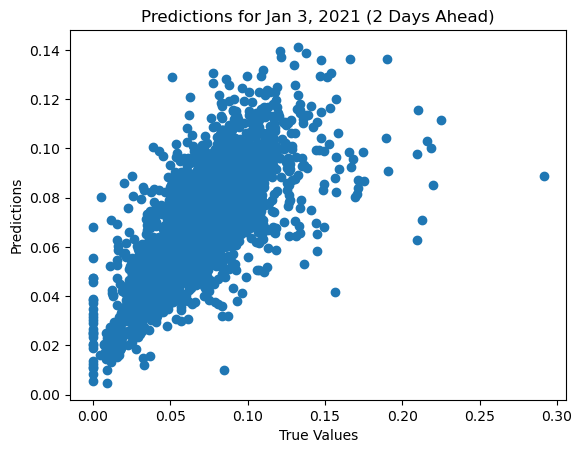

In [33]:
plt.scatter(x = Y_jan_3, y = pred_jan_3)
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title("Predictions for Jan 3, 2021 (2 Days Ahead)");

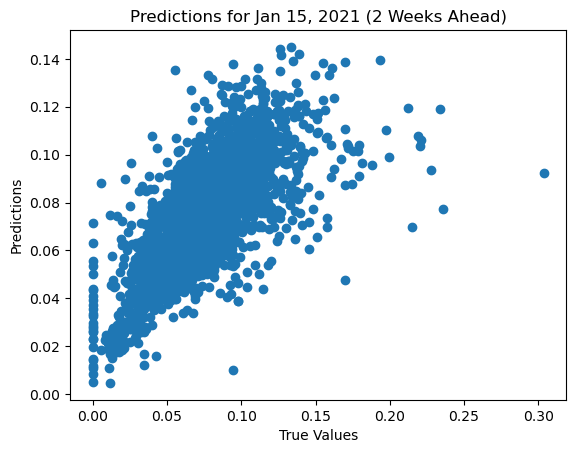

In [34]:
plt.scatter(x = Y_jan_15, y = pred_jan_15)
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title("Predictions for Jan 15, 2021 (2 Weeks Ahead)");

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 6e

Plot and describe the error for both the baseline and improved models as a function of time. In other words, given $x_t$, we wish to predict $\hat{x}_{t+k}$, and plot the error of these predictions for all $k$.

Consider how and why the performance of the model degrades as a function of time using the rate of growth in the error.

<!--
BEGIN QUESTION
name: q6e
points: 0
manual: True
-->

In [35]:
#adding case data
cases_per_capita_6e = county_data.copy()
cases_per_capita_6e['1/12/21'] = cases_per_capita_6e.loc[:, '1/12/21'].divide(cases_per_capita_6e['POPESTIMATE2020'], axis=0)
cases_per_capita_6e = cases_per_capita_6e[['1/12/21', 'COUNTYFP']]
cases_per_capita_6e = cases_per_capita_6e[~(cases_per_capita_6e["COUNTYFP"].isin([2261, 2158, 46102]))].reset_index()

#Iterate over cases_per_capita_6 and add neighboring county case rates
all_neighbors = []
for index, row in cases_per_capita_6e.iterrows():
    neighbors = []
    for i in find_adjacent(row['COUNTYFP']):
        if i in cases_per_capita_6e['COUNTYFP'].values:
            neighbor = (cases_per_capita_6e[cases_per_capita_6e['COUNTYFP']==i])
            case_rate = neighbor['1/12/21'].iloc[0]
            neighbors.append(case_rate)
    all_neighbors.append(neighbors)
cases_per_capita_6e['neighbors_caserate'] = all_neighbors
separated_caseneighbors_6e = pd.DataFrame([pd.Series(x) for x in cases_per_capita_6e.neighbors_caserate])

#Drop neighbors over 7 and impute NaN values with the row mean
separated_caseneighbors_6e = separated_caseneighbors_6e.drop(np.arange(7,len(separated_caseneighbors_6e.columns)), axis=1).apply(lambda row: row.fillna(row.mean()), axis=1)
#Readd COUNTYFP values
separated_caseneighbors_6e['COUNTYFP'] = cases_per_capita_6e['COUNTYFP']
#Merge with mask data
part6e_data = part6_data.merge(separated_caseneighbors_6e, on='COUNTYFP', how='inner', suffixes=('mask', 'case'))
part6e_data.head()

,0mask,1mask,2mask,3mask,4mask,5mask,6mask,COUNTYFP,0case,1case,2case,3case,4case,5case,6case
0,0.618,0.524,0.485,0.464,0.513,0.5208,0.520800,1001,0.074329,0.081971,0.091689,0.111088,0.081531,0.088122,0.088122
1,0.430,0.387,0.506,0.378,0.495,0.5240,0.453333,1003,0.113735,0.083653,0.070293,0.069212,0.082999,0.080384,0.083379
2,0.500,0.460,0.438,0.330,0.570,0.5620,0.538000,1005,0.096933,0.077616,0.084654,0.072317,0.053317,0.069784,0.051959
3,0.618,0.639,0.628,0.618,0.545,0.5320,0.596667,1007,0.074329,0.115542,0.091352,0.107057,0.080554,0.096414,0.094208
4,0.379,0.501,0.628,0.479,0.495,0.4290,0.485167,1009,0.092244,0.109963,0.091352,0.102145,0.080506,0.091459,0.094611


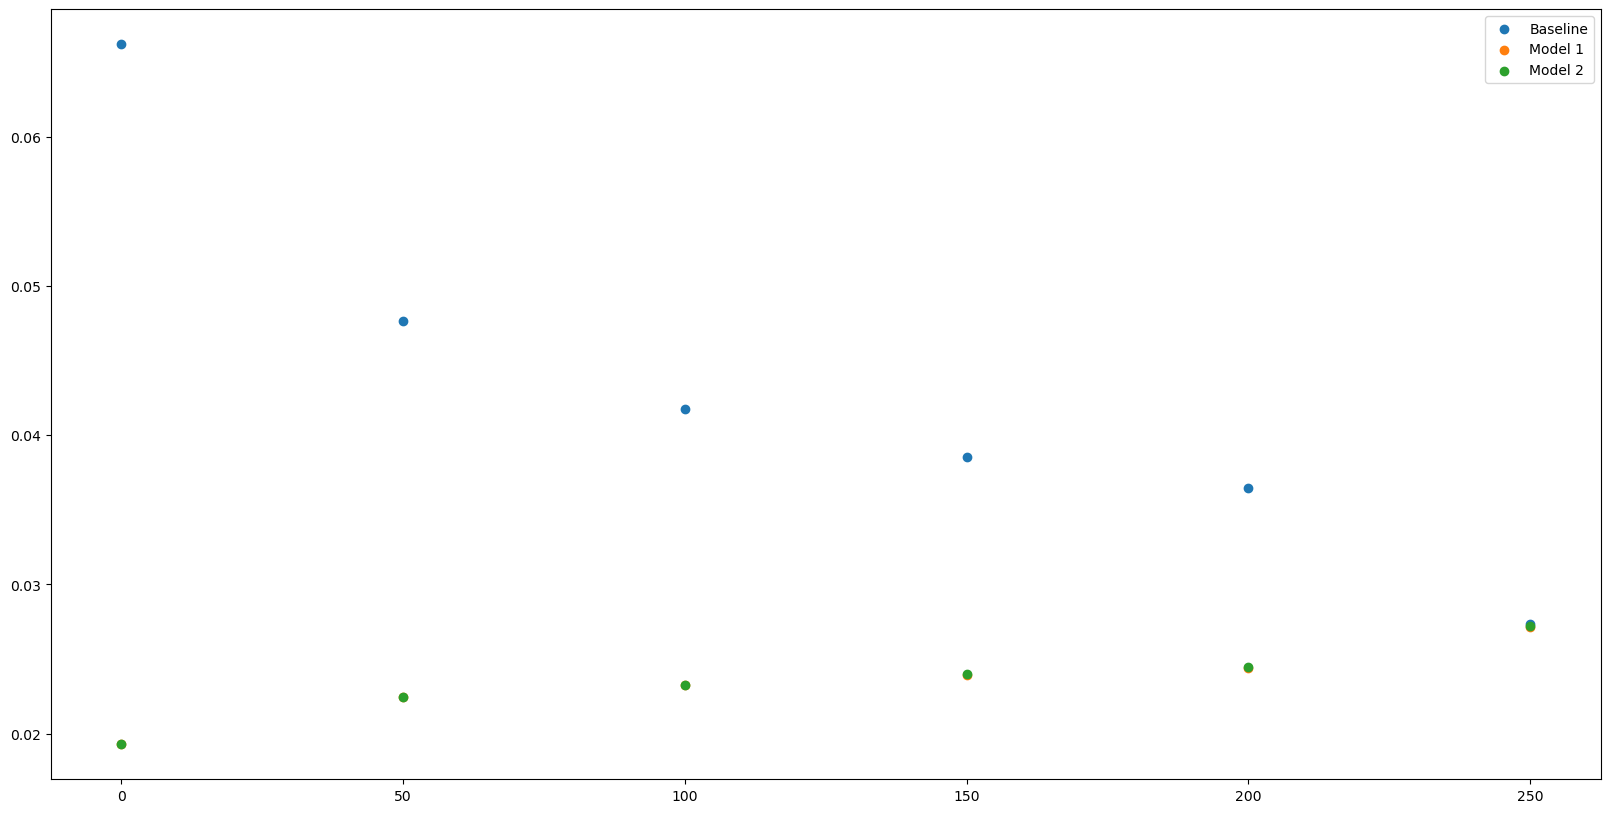

In [36]:
#Create model 2
model6e=LinearRegression()
#train on new design matrix that also includes vaccination data
X_model2_train_6e = vaccinations_day("2021-01-01", X_jan_1)
#Removing outliers for model 2
X_model2_train_6e = X_model2_train_6e[~(X_model2_train_6e["COUNTYFP"].isin([13053, 8025]))]

Y_model2_train_6e = part6_countydata.copy()
Y_model2_train_6e['1/1/21'] = Y_model2_train_6e.loc[:, '1/1/21'].divide(Y_model2_train_6e['POPESTIMATE2020'], axis=0)
Y_model2_train_6e = Y_model2_train_6e[['1/1/21', 'COUNTYFP']]
Y_model2_train_6e = Y_model2_train_6e[~(Y_model2_train_6e["COUNTYFP"].isin([13053, 8025]))]
Y_model2_train_6e = Y_model2_train_6e['1/1/21']
Y_model2_train_6e

model6e.fit(X_model2_train_6e, Y_model2_train_6e)

baseline_RMSE = []
model1_RMSE = []
model2_RMSE = []
baseline_R2 = []
model1_R2 = []
model2_R2 = []
day_range = np.arange(0, 255, 50)

baseline_pred = np.mean(cases_day("1/1/21").iloc[:, 8:14], axis=1)
#For each of the 255 days between jan 1, 2021 to september 12, 2021
for day in day_range:
    date = county_data.columns[377 + day]
    X_for_day = cases_day(date)
    day_actual = case_count_per_capita(date)
    #Baseline Model
    baseline_RMSE.append(rmse(day_actual, baseline_pred))
    #Improved Model 1 Predictions
    m1_predictions = model6d.predict(X_for_day)
    model1_RMSE.append(rmse(day_actual, m1_predictions))
    model1_R2.append(r2_score(day_actual, m1_predictions))
    #Improved Model 2 Predictions
    X_for_day_m2 = vaccinations_day(str(pd.to_datetime(date))[:10], X_for_day)
    m2_predictions = model6e.predict(X_for_day_m2)
    model2_RMSE.append(rmse(day_actual, m2_predictions))
    model2_R2.append(r2_score(day_actual, m2_predictions))

plt.figure(figsize=(20,10))
plt.scatter(day_range, baseline_RMSE, label = "Baseline")
plt.scatter(day_range, model1_RMSE, label = "Model 1")
plt.scatter(day_range, model2_RMSE, label = "Model 2")
plt.legend();

In [37]:
print('Summary')
print(f"Baseline Test RMSE: {baseline_rmse}")
print(f"Baseline Test R^2: {baseline_r2}")
print(f"Model Train RMSE: {trainrmse_6a}")
print(f"Model Train R^2: {trainr2_6a}")
print(f"Improved Model Train RMSE: {trainrmse_6b}")
print(f"Improved Model Train R^2: {trainr2_6b}")
print(f"Model Test RMSE: {testrmse_6a}")
print(f"Model Test R^2: {testr2_6a}")
print(f"Improved Model Test RMSE: {testrmse_6b}")
print(f"Improved Model Test R^2: {testr2_6b}")
print()
print(f"Model RMSE for 2 days ahead: {rmse_2day} \n Model RMSE for 2 weeks ahead: {rmse_2week} \n Baseline RMSE for 2 days ahead: {rmse_baseline_2day} \n Baseline RMSE for 2 weeks ahead: {rmse_baseline_2week}")

Summary
Baseline Test RMSE: 0.02878011117332395
Baseline Test R^2: 0.44365947058401967
Model Train RMSE: 0.02616179134344437
Model Train R^2: 0.5021372504101781
Improved Model Train RMSE: 0.025677239057559722
Improved Model Train R^2: 0.5190834920945658
Model Test RMSE: 0.02846628215832868
Model Test R^2: 0.45572640601700676
Improved Model Test RMSE: 0.02591072112096292
Improved Model Test R^2: 0.48557062306933374

Model RMSE for 2 days ahead: 0.019438078688468592 
 Model RMSE for 2 weeks ahead: 0.020398550339936244 
 Baseline RMSE for 2 days ahead: 0.06500161568388789 
 Baseline RMSE for 2 weeks ahead: 0.05791463965653096


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 6f

Consider a modification to the model $f(x) = x_{t+1}$ where instead $f(x) = [x_{t+1}, x_{t+2}, ..., x_{t+m}]$ for some $m > 1$. In other words, using the features $x$ that contain past and present quantities, our model *explicitly* predicts values for $m$ days in the future rather than simply the next day (i.e. $m = 1$). 

Train the baseline and improved model using $m = 5$ and $m = 10$. Evaluate and visualize the predictive accuracy of both models.

<!--
BEGIN QUESTION
name: q6f
points: 0
manual: True
-->

---

To double-check your work, the cell below will rerun all of the autograder tests.

In [38]:
grader.check_all()

q1a results: All test cases passed!

q1d results: All test cases passed!

q1e results: All test cases passed!

q5b results: All test cases passed!

q5d results: All test cases passed!

q5f results: All test cases passed!

q5g results: All test cases passed!

q5i results: All test cases passed!

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [39]:
# Save your notebook first, then run this cell to export your submission.
grader.export()

There was an error generating your LaTeX
Showing concise error message
! 
! For immediate help type H <return>.
!...............................................  
                                                  
l.316 \begin{document}
                      
? 
! Emergency stop.
!...............................................  
                                                  
l.316 \begin{document}
                      
No pages of output.
Transcript written on notebook.log.

